<h1> Time series prediction, end-to-end </h1>

This notebook illustrates several models to find the next value of a time-series:
<ol>
<li> Linear
<li> DNN
<li> CNN 
<li> RNN
</ol>

In [1]:
# change these to try this notebook out
BUCKET = 'qwiklabs-gcp-2716f1e6e1bf2a04'
PROJECT = 'qwiklabs-gcp-2716f1e6e1bf2a04'
REGION = 'us-central1'
SEQ_LEN = 50

In [2]:
import os
os.environ['BUCKET'] = BUCKET
os.environ['PROJECT'] = PROJECT
os.environ['REGION'] = REGION
os.environ['SEQ_LEN'] = str(SEQ_LEN)
os.environ['TFVERSION'] = '1.8'

<h3> Simulate some time-series data </h3>

Essentially a set of sinusoids with random amplitudes and frequencies.

In [3]:
import tensorflow as tf
print(tf.__version__)

/usr/local/envs/py3env/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


1.8.0


/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


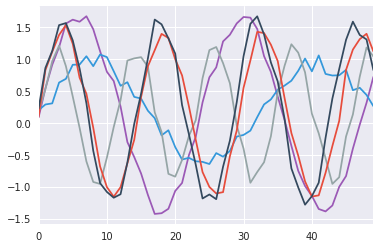

In [4]:
import numpy as np
import seaborn as sns

def create_time_series():
  freq = (np.random.random()*0.5) + 0.1  # 0.1 to 0.6
  ampl = np.random.random() + 0.5  # 0.5 to 1.5
  noise = [np.random.random()*0.3 for i in range(SEQ_LEN)] # -0.3 to +0.3 uniformly distributed
  x = np.sin(np.arange(0,SEQ_LEN) * freq) * ampl + noise
  return x

flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
for i in range(0, 5):
  sns.tsplot( create_time_series(), color=flatui[i%len(flatui)] );  # 5 series

In [5]:
def to_csv(filename, N):
  with open(filename, 'w') as ofp:
    for lineno in range(0, N):
      seq = create_time_series()
      line = ",".join(map(str, seq))
      ofp.write(line + '\n')

import os
try:
  os.makedirs('data/sines/')
except OSError:
  pass
to_csv('data/sines/train-1.csv', 1000)  # 1000 sequences
to_csv('data/sines/valid-1.csv', 250)

In [6]:
!head -5 data/sines/*-1.csv

==> data/sines/train-1.csv <==
0.03664899536370184,0.4457454872761391,0.7514571462112589,1.1826052822832576,1.2014768483827296,0.8819123873830391,0.6139411527051583,0.42990693696395893,-0.0378783515648034,-0.5605235706740777,-0.6208340704301942,-0.7437742701065455,-0.8130202428307431,-0.6877664891114746,-0.06828525778410482,0.24296505128082174,0.5809598364279245,0.890003279800227,0.9448187824397356,1.0475659925320393,1.0684500534964945,0.6701618263954469,0.19705964070589993,-0.22528779978635555,-0.5152733497313466,-0.7083319940353657,-0.8193018116094373,-0.8064784117084686,-0.42337069711026054,-0.24578354404787509,0.1504769984126115,0.5316376936613931,0.8546619027935415,1.1865290840416913,1.0670815498751203,0.9169575641715639,0.6370649187334619,0.3943718605168709,-0.12220912267279863,-0.5867097221891121,-0.7299707138566144,-0.708928862818082,-0.6878937715293054,-0.5547851869150896,-0.06333671491633724,0.1286527652002027,0.7119374681635373,0.8649074100259845,1.2104716383736425,0.9783761

<h3> Train model locally </h3>

Make sure the code works as intended.

The `model.py` and `task.py` containing the model code is in <a href="sinemodel">sinemodel/</a>

**Complete the TODOs in `model.py` before proceeding!**

Once you've completed the TODOs, set `--model` below to the appropriate model (linear,dnn,cnn,rnn,rnn2 or rnnN) and run it locally for a few steps to test the code.

In [7]:
%%bash
DATADIR=$(pwd)/data/sines
OUTDIR=$(pwd)/trained/sines
rm -rf $OUTDIR
gcloud ml-engine local train \
   --module-name=sinemodel.task \
   --package-path=${PWD}/sinemodel \
   -- \
   --train_data_path="${DATADIR}/train-1.csv" \
   --eval_data_path="${DATADIR}/valid-1.csv"  \
   --output_dir=${OUTDIR} \
   --model=dnn --train_steps=10 --sequence_length=$SEQ_LEN

/usr/local/envs/py3env/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
INFO:tensorflow:TF_CONFIG environment variable: {'environment': 'cloud', 'job': {'job_name': 'sinemodel.task', 'args': ['--train_data_path=/content/datalab/notebooks/training-data-analyst/courses/machine_learning/deepdive/09_sequence/labs/data/sines/train-1.csv', '--eval_data_path=/content/datalab/notebooks/training-data-analyst/courses/machine_learning/deepdive/09_sequence/labs/data/sines/valid-1.csv', '--output_dir=/content/datalab/notebooks/training-data-analyst/courses/machine_learning/deepdive/09_sequence/labs/trained/sines', '--model=dnn', '--train_steps=10', '--sequence_length=50']}, 'task': {}, 'cluster': {}}
INFO:tensorflow:Using config: {'_num_worker_replicas': 1, '

<h3> Cloud ML Engine </h3>

Now to train on Cloud ML Engine with more data.

In [8]:
import shutil
shutil.rmtree('data/sines', ignore_errors=True)
os.makedirs('data/sines/')
for i in range(0,10):
  to_csv('data/sines/train-{}.csv'.format(i), 1000)  # 1000 sequences
  to_csv('data/sines/valid-{}.csv'.format(i), 250)

In [9]:
%%bash
gsutil -m rm -rf gs://${BUCKET}/sines/*
gsutil -m cp data/sines/*.csv gs://${BUCKET}/sines

CommandException: 1 files/objects could not be removed.
Copying file://data/sines/train-0.csv [Content-Type=text/csv]...
Copying file://data/sines/train-1.csv [Content-Type=text/csv]...
Copying file://data/sines/train-2.csv [Content-Type=text/csv]...
Copying file://data/sines/train-3.csv [Content-Type=text/csv]...
Copying file://data/sines/train-4.csv [Content-Type=text/csv]...
Copying file://data/sines/train-5.csv [Content-Type=text/csv]...
Copying file://data/sines/train-6.csv [Content-Type=text/csv]...
Copying file://data/sines/train-7.csv [Content-Type=text/csv]...
Copying file://data/sines/train-8.csv [Content-Type=text/csv]...
Copying file://data/sines/train-9.csv [Content-Type=text/csv]...
Copying file://data/sines/valid-0.csv [Content-Type=text/csv]...
Copying file://data/sines/valid-1.csv [Content-Type=text/csv]...
Copying file://data/sines/valid-2.csv [Content-Type=text/csv]...
Copying file://data/sines/valid-3.csv [Content-Type=text/csv]...
Copying file://data/sines/valid-4.

In [10]:
%%bash
for MODEL in linear dnn cnn rnn rnn2 rnnN; do
  OUTDIR=gs://${BUCKET}/sinewaves/${MODEL}
  JOBNAME=sines_${MODEL}_$(date -u +%y%m%d_%H%M%S)
  gsutil -m rm -rf $OUTDIR
  gcloud ml-engine jobs submit training $JOBNAME \
     --region=$REGION \
     --module-name=sinemodel.task \
     --package-path=${PWD}/sinemodel \
     --job-dir=$OUTDIR \
     --staging-bucket=gs://$BUCKET \
     --scale-tier=BASIC_GPU \
     --runtime-version=$TFVERSION \
     -- \
     --train_data_path="gs://${BUCKET}/sines/train*.csv" \
     --eval_data_path="gs://${BUCKET}/sines/valid*.csv"  \
     --output_dir=$OUTDIR \
     --train_steps=3000 --sequence_length=$SEQ_LEN --model=$MODEL
done

jobId: sines_linear_190408_171520
state: QUEUED
jobId: sines_dnn_190408_171527
state: QUEUED
jobId: sines_cnn_190408_171530
state: QUEUED
jobId: sines_rnn_190408_171533
state: QUEUED
jobId: sines_rnn2_190408_171537
state: QUEUED
jobId: sines_rnnN_190408_171540
state: QUEUED


CommandException: 1 files/objects could not be removed.
Job [sines_linear_190408_171520] submitted successfully.
Your job is still active. You may view the status of your job with the command

  $ gcloud ml-engine jobs describe sines_linear_190408_171520

or continue streaming the logs with the command

  $ gcloud ml-engine jobs stream-logs sines_linear_190408_171520
CommandException: 1 files/objects could not be removed.
Job [sines_dnn_190408_171527] submitted successfully.
Your job is still active. You may view the status of your job with the command

  $ gcloud ml-engine jobs describe sines_dnn_190408_171527

or continue streaming the logs with the command

  $ gcloud ml-engine jobs stream-logs sines_dnn_190408_171527
CommandException: 1 files/objects could not be removed.
Job [sines_cnn_190408_171530] submitted successfully.
Your job is still active. You may view the status of your job with the command

  $ gcloud ml-engine jobs describe sines_cnn_190408_171530

or continue streami

## Monitor training with TensorBoard

Use this cell to launch tensorboard. If tensorboard appears blank try refreshing after 5 minutes

In [ ]:
from google.datalab.ml import TensorBoard
TensorBoard().start('gs://{}/sinewaves'.format(BUCKET))

In [ ]:
for pid in TensorBoard.list()['pid']:
  TensorBoard().stop(pid)
  print('Stopped TensorBoard with pid {}'.format(pid))

## My Results:

In [11]:
%bash
gcloud ml-engine jobs describe sines_dnn_190408_171527

createTime: '2019-04-08T17:15:30Z'
etag: -FxlgWTGS18=
jobId: sines_dnn_190408_171527
startTime: '2019-04-08T17:16:53Z'
state: RUNNING
trainingInput:
  args:
  - --train_data_path=gs://qwiklabs-gcp-2716f1e6e1bf2a04/sines/train*.csv
  - --eval_data_path=gs://qwiklabs-gcp-2716f1e6e1bf2a04/sines/valid*.csv
  - --output_dir=gs://qwiklabs-gcp-2716f1e6e1bf2a04/sinewaves/dnn
  - --train_steps=3000
  - --sequence_length=50
  - --model=dnn
  jobDir: gs://qwiklabs-gcp-2716f1e6e1bf2a04/sinewaves/dnn
  packageUris:
  - gs://qwiklabs-gcp-2716f1e6e1bf2a04/sines_dnn_190408_171527/0ab139c3a6311e07a1d2475ed66dc2a5cd78b7ba54e4f02fb38c097276be9df7/sinemodel-0.0.0.tar.gz
  pythonModule: sinemodel.task
  region: us-central1
  runtimeVersion: '1.8'
  scaleTier: BASIC_GPU
trainingOutput:
  consumedMLUnits: 0.07



View job in the Cloud Console at:
https://console.cloud.google.com/ml/jobs/sines_dnn_190408_171527?project=qwiklabs-gcp-2716f1e6e1bf2a04

View logs at:
https://console.cloud.google.com/logs?resource=ml.googleapis.com%2Fjob_id%2Fsines_dnn_190408_171527&project=qwiklabs-gcp-2716f1e6e1bf2a04


## Results

Complete the below table with your own results! Then compare your results to the results in the solution notebook.

| Model | Sequence length | # of steps | Minutes | RMSE |
| --- | ----| --- | --- | --- | 
| linear | 50 | 3000 | - | - |
| dnn | 50 | 3000 | 132 sec | 0.09863432 |
| cnn | 50 | 3000 | - | - |
| rnn | 50 | 3000 | - | - |
| rnn2 | 50 | 3000 | - | - |
| rnnN | 50 | 3000 | - | - |

Copyright 2017 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License